In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
%pip install -q spuco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.0/101.0 kB 810.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:

%pip install -q pytorch-metric-learning
!pip install -q accelerate -U
!pip install -q transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty
import torchvision.transforms as transforms
import cv2
import torchvision.models as models
from pytorch_metric_learning import losses
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda")

In [5]:
magnitude_dict = {
    "SMALL": SpuriousFeatureDifficulty.MAGNITUDE_SMALL,
    "MEDIUM":SpuriousFeatureDifficulty.MAGNITUDE_MEDIUM,
    "LARGE":SpuriousFeatureDifficulty.MAGNITUDE_LARGE,
}

magnitude = 'MEDIUM'
class Config:
    spurious_correlation_strength  = 0.995
    spurious_feature_difficulty = magnitude_dict[magnitude]
    label_noise = 0.001
    size = 28
    flip_probability = 0.5
    batch_size = 256
    backbone_pretrained = False
    projection_dim = 128
    T_max = 10
    lr = 5e-4
    min_lr = 1e-5
    weight_decay = 1e-6
    temperature = 0.5

## Dataset

In [6]:

classes = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
difficulty = SpuriousFeatureDifficulty.MAGNITUDE_LARGE

trainset = SpuCoMNIST(
    root="/data/mnist/",
    spurious_feature_difficulty=Config.spurious_feature_difficulty,
    spurious_correlation_strength=Config.spurious_correlation_strength,
    classes=classes,
    split="train",
    label_noise=Config.label_noise
)
trainset.initialize()

valset = SpuCoMNIST(
    root="/data/mnist/",
    spurious_feature_difficulty=Config.spurious_feature_difficulty,
    spurious_correlation_strength=Config.spurious_correlation_strength,
    classes=classes,
    split="test",
    label_noise=Config.label_noise
)
valset.initialize()


100%|██████████| 9912422/9912422 [00:00<00:00, 71475474.82it/s]


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6273210.45it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22562095.33it/s]


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14007741.74it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw




100%|██████████| 10000/10000 [00:01<00:00, 5766.77it/s]


In [7]:

## Augmentation
from torchvision.transforms import v2

train_transform = transforms.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(Config.size, scale=(0.08, 1.0), ratio=(0.75, 1.25)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomApply([v2.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    v2.RandomGrayscale(p=0.2),
    v2.ToTensor(),
    v2.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    v2.ToImage(),
    v2.ToTensor(),
    v2.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
class SpucoDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img = self.dataset[index][0]
        label = self.dataset[index][1]

        if self.transform is None:
          self.transform = transforms.Compose([
          v2.ToImage(),
          v2.ToTensor(),
          v2.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

        augmented_img = self.transform(img)
        return augmented_img

In [9]:
train_dataset = SpucoDataset(trainset, train_transform)
val_dataset = SpucoDataset(valset, test_transform)

def collator_fn(batch):
  #return batch
  return { 'pixel_values': torch.stack(batch)
           }



## Model

In [10]:
## https://github.com/berfukaraca/SSL-Cifar10-ContrastiveLearning/blob/main/colab_notebooks/SSL_SimCLR_Cifar10_CL.ipynb

from transformers import ViTMAEConfig, ViTMAEForPreTraining

modelConfig = ViTMAEConfig(
    hidden_size = 48,
    num_hidden_layers = 4,
    num_attention_heads = 4,
    intermediate_size = 256,
    hidden_act = 'gelu',
    hidden_dropout_prob = 0.0,
    attention_probs_dropout_prob = 0.0,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12,
    image_size = 28,
    patch_size = 2,
    num_channels = 3,
    qkv_bias = True,
    decoder_num_attention_heads = 8,
    decoder_hidden_size = 64,
    decoder_num_hidden_layers = 6,
    decoder_intermediate_size = 224,
    mask_ratio = 0.75,
    norm_pix_loss = False
)



In [11]:

## model and optimizer
model = ViTMAEForPreTraining(modelConfig)
# print(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 48, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-3): 4 x ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=48, out_features=48, bias=True)
              (key): Linear(in_features=48, out_features=48, bias=True)
              (value): Linear(in_features=48, out_features=48, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=48, out_features=48, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=48, out_features=256, bias=True)
        

In [12]:
from transformers import Trainer, TrainingArguments
args = TrainingArguments(
    output_dir = f"/content/drive/MyDrive/CS260D_final_project/model_parameters/ViTMAE/MNIST/{Config.spurious_correlation_strength}_{magnitude}/",
    evaluation_strategy = "epoch",
    label_names = ["pixel_values"],
    #eval_delay  = 2,
    logging_steps = 100,
    per_device_train_batch_size = Config.batch_size,
    per_device_eval_batch_size = Config.batch_size,
    learning_rate = 5e-4,
    num_train_epochs = 30,
    #lr_scheduler_type = "linear",
    save_strategy = "epoch",
    dataloader_num_workers = 2,
    load_best_model_at_end = True,
    fp16 = False,
    remove_unused_columns= False
)

In [13]:
class CustomTrainer(Trainer):

  def get_train_dataloader(self):
    collator = self.data_collator
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=self.args.per_device_train_batch_size, num_workers=2, pin_memory=True, shuffle=True, collate_fn = collator)
    return train_dataloader

  def get_eval_dataloader(self, eval_dataset):
    collator = self.data_collator
    eval_dataset = eval_dataset if eval_dataset is not None else self.eval_dataset
    eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=self.args.per_device_eval_batch_size, num_workers=2, pin_memory=True, shuffle=False, collate_fn = collator)
    return eval_dataloader

  def get_test_dataloader(self, test_dataset):
    collator = self.data_collator
    test_dataset = test_dataset if test_dataset is not None else self.test_dataset
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=self.args.per_device_eval_batch_size, num_workers=2, pin_memory=True, shuffle=False, collate_fn = collator)
    return test_dataloader



trainer = CustomTrainer(
    model = model,
    args = args,
    data_collator = collator_fn,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch,Training Loss,Validation Loss


In [ ]:
trainer.train(resume_from_checkpoint = True)

Could not locate the best model at /content/drive/MyDrive/CS260D_final_project/model_parameters/ViTMAE/MNIST/SpuriousFeatureDifficulty.MAGNITUDE_SMALL_SMALL/checkpoint-5640/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=5640, training_loss=0.0, metrics={'train_runtime': 0.7937, 'train_samples_per_second': 1814512.879, 'train_steps_per_second': 7106.25, 'total_flos': 8942027021706240.0, 'train_loss': 0.0, 'epoch': 30.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6467647552490234,
 'eval_runtime': 293.5054,
 'eval_samples_per_second': 34.071,
 'eval_steps_per_second': 0.136,
 'epoch': 30.0}

In [ ]:
val_dataset_transform = SpucoDataset(valset, train_transform)

In [ ]:
trainer.eval_dataset = val_dataset_transform
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

{'eval_loss': 0.2567386031150818,
 'eval_runtime': 298.122,
 'eval_samples_per_second': 33.543,
 'eval_steps_per_second': 0.134,
 'epoch': 30.0}

## PCA and 2D Scatter Plot

In [ ]:
torch.cuda.empty_cache()


In [ ]:
class SpucoDatasetwithLabels(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img = self.dataset[index][0]
        label = self.dataset[index][1]

        if self.transform is None:
          self.transform = transforms.Compose([
          v2.ToImage(),
          v2.ToTensor(),
          v2.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

        augmented_img = self.transform(img)
        return augmented_img, label

In [ ]:
## https://www.kaggle.com/code/minc33/visualizing-high-dimensional-clusters

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm



torch.cuda.empty_cache()
device = 'cpu'
model.to(device)

val_dataset_labels = SpucoDatasetwithLabels(valset)
val_dataloader = DataLoader(dataset=val_dataset_labels, batch_size=Config.batch_size, num_workers=2, pin_memory=True, shuffle=False)



In [ ]:
from IPython.display import display
for (k, v) in trainset.group_partition.items():
  print(f"Group: {k}, Qty: {len(v)}")
  img = T.ToPILImage()(trainset[v[0]][0])
  display(img)

Group: (2, 2), Qty: 8951


Group: (0, 0), Qty: 10075


Group: (4, 4), Qty: 9382


Group: (1, 1), Qty: 9621


Group: (3, 3), Qty: 9686


Group: (0, 4), Qty: 8


Group: (0, 3), Qty: 18


Group: (3, 4), Qty: 16


Group: (1, 4), Qty: 15


Group: (3, 2), Qty: 14


Group: (2, 3), Qty: 13


Group: (2, 4), Qty: 20


Group: (4, 1), Qty: 7


Group: (3, 0), Qty: 11


Group: (2, 0), Qty: 8


Group: (4, 0), Qty: 15


Group: (1, 2), Qty: 21


Group: (2, 1), Qty: 12


Group: (4, 3), Qty: 18


Group: (0, 2), Qty: 20


Group: (1, 0), Qty: 19


Group: (3, 1), Qty: 11


Group: (0, 1), Qty: 16


Group: (4, 2), Qty: 20


Group: (1, 3), Qty: 7


In [ ]:
torch.cuda.empty_cache()

In [ ]:

embeddings = []
targets = []
loss = []
for batch_idx, (images, labels) in enumerate(val_dataloader):
  encoded_output = model.vit(images)
  #decoded_output = model.decoder(**encoded_output)
  embeddings.append(encoded_output['last_hidden_state'][:, 0, :].flatten(1, -1).detach().cpu())
  targets.append(labels)
  #output = model(images)
  #loss.append(output['loss'].detach().cpu().numpy())
  torch.cuda.empty_cache()

embeddings = torch.cat(embeddings).detach().cpu().numpy()
targets = torch.cat(targets).cpu().numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
import gc
gc.collect()

0

In [ ]:
targets.shape

(10000,)

In [ ]:
import pandas as pd
comp = 25
pca_2d = PCA(n_components=comp)
PCs_2d = pd.DataFrame(pca_2d.fit_transform(embeddings))
PCs_2d.columns = [f"PC{i+ 1}" for i in range(comp)]
pca_embs = pd.concat([pd.DataFrame(embeddings),PCs_2d], axis=1, join='inner')

In [ ]:
pca_embs['true_label'] = targets

In [ ]:
pca_2d.singular_values_

array([103.7241    ,  18.144196  ,  10.434965  ,   9.043334  ,
         6.5896854 ,   3.9844131 ,   3.5331006 ,   3.0819466 ,
         2.8208032 ,   2.2886548 ,   1.8117172 ,   1.7597351 ,
         1.5437974 ,   1.3884093 ,   1.1546743 ,   1.0545243 ,
         0.95443785,   0.8466036 ,   0.7548937 ,   0.6838426 ,
         0.62485874,   0.5755387 ,   0.5092952 ,   0.47703522,
         0.42137894], dtype=float32)

In [ ]:
pca_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,true_label
0,-0.370545,0.306599,-0.395164,-0.516901,0.327490,-0.095195,1.932578,0.878636,-0.570764,-2.390268,...,0.005780,-0.021693,-0.016440,0.014519,0.007292,-0.001708,0.009416,0.008039,-0.000809,3
1,-0.539056,0.280740,-0.458908,-0.027450,0.025852,-0.122101,2.122277,1.266846,-0.638651,-2.173731,...,-0.015587,0.000818,-0.005666,0.002527,0.006101,0.004652,-0.002737,-0.001525,0.004429,1
2,-0.325869,0.242491,-0.369058,-0.650078,0.405203,-0.077563,1.850373,0.809309,-0.684728,-2.394808,...,-0.000033,0.006585,0.001725,0.006940,-0.001214,-0.008388,-0.005383,0.004268,0.004274,0
3,-0.627962,0.267080,-0.482091,0.252231,-0.074163,-0.095385,2.163042,1.437684,-0.687806,-2.088330,...,0.006568,0.001053,-0.005709,-0.004950,-0.000678,-0.007244,-0.001988,-0.001127,-0.008578,0
4,-0.379065,0.187907,-0.360538,-0.466074,0.380705,-0.030257,1.900206,0.937278,-0.697477,-2.338340,...,0.008623,-0.004494,0.014009,-0.003137,0.001346,-0.009481,-0.000962,-0.004165,-0.005945,2


In [ ]:
clusters = {k : np.stack([PCs_2d.loc[i].values for i in v]) for (k, v) in valset.group_partition.items()}

In [ ]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

traces = []

for (k, v) in sorted(clusters.items()):
  traces.append(go.Scatter(
                    x = v[:, 1],
                    y = v[:, 2],
                    #z = v[:, 2],
                    mode = "markers",
                    name = "True label {}, Subgroup {}".format(k[0], k[1]),
                    text = None))

In [ ]:
data = traces

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [ ]:
# Do PCA/t-SNE on each true label
for (true, spur), idxs in valset.group_partition.items():
  for i in idxs:
    pca_embs.loc[i, 'spurious_label'] = spur
pca_embs['spurious_label'] = pca_embs['spurious_label'].astype(int)

In [ ]:
true_label_clusters = {
    # True label: {group, cluster_dim}
}
for l in pca_embs['true_label'].unique():
  true_cluster = pca_embs[pca_embs['true_label'] == l]
  true_emb = true_cluster.iloc[:, :128].values
  pca = PCA(n_components=3)
  PCs = pd.DataFrame(pca.fit_transform(true_emb), columns = ['PC1_TL', 'PC2_TL', 'PC3_TL'])
  PCs = pd.concat([PCs,true_cluster[['true_label', 'spurious_label']]], axis=1, join='inner')
  true_label_clusters[l] = PCs
  # pca_embs = pd.concat([pd.DataFrame(embeddings),PCs_2d], axis=1, join='inner')


In [ ]:
pca.singular_values_

array([62.97008341, 51.38595804,  7.79307049])

In [ ]:
spurious_label_clusters = {
    # Spurious label: {group, cluster_dim}
}
for l in pca_embs['spurious_label'].unique():
  spurious_cluster = pca_embs[pca_embs['spurious_label'] == l]
  spurious_emb = spurious_cluster.iloc[:, :128].values
  pca = PCA(n_components=3)
  PCs = pd.DataFrame(pca.fit_transform(embeddings), columns = ['PC1_SL', 'PC2_SL', 'PC3_SL'])
  PCs = pd.concat([PCs,spurious_cluster[['true_label', 'spurious_label']]], axis=1, join='inner')
  spurious_label_clusters[l] = PCs
  # pca_embs = pd.concat([pd.DataFrame(embeddings),PCs_2d], axis=1, join='inner')


In [ ]:
pca.singular_values_

array([103.7241  ,  18.1442  ,  10.434964], dtype=float32)

In [ ]:
from sklearn.manifold import TSNE
perplexity = 50

#T-SNE with two dimensions
tsne = TSNE(n_components=3, perplexity=perplexity)
clusters = {}
for label in pca_embs['class_label'].unique():
  label_df = pca_embs[pca_embs['class_label'] == label]
  label_df.reset_index()
  label_embs = label_df.iloc[:, :128].values
  TCs = pd.DataFrame(tsne.fit_transform(label_embs))
  TCs.columns = ["TC1","TC2", "TC3"]
  label_df = pd.concat([label_df, TCs], axis = 1, join = 'inner')
  clusters[label] = label_df



In [ ]:
pca.singular_values_

array([104.155174,  18.48044 ,  10.171163], dtype=float32)

In [ ]:
import os

save_dir = f"/content/drive/MyDrive/CS260D_final_project/model_parameters/ViTMAE/MNIST/{Config.spurious_correlation_strength}_{magnitude}/plot"
for k, v in true_label_clusters.items():
  traces = []
  for s in np.sort(v['spurious_label'].unique()):
    group = v[v['spurious_label'] == s]
    traces.append(go.Scatter(
                      x = group['PC1_TL'],
                      y = group['PC2_TL'],
                      #z = group['PC3_TL'],
                      mode = "markers",
                      name = f"Subgroup {s}",
                      text = None))
  data = traces

  title = f"Visualizing Clusters in Two Dimensions Using PCA - True Label {k}"

  layout = dict(title = title,
                xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
              )

  fig = dict(data = data, layout = layout)
  save_name = f"ViTMAE_{Config.spurious_correlation_strength}_{magnitude}_TL{k}_PCA_plot.html"
  if os.path.isdir(save_dir):
    go.Figure.write_html(fig, os.path.join(save_dir, save_name))
  else:
    os.mkdir(save_dir)
    go.Figure.write_html(fig, os.path.join(save_dir, save_name))

  iplot(fig)

In [ ]:
import os

# save_dir = f"/content/drive/MyDrive/CS260D_final_project/changing_spurious_correlation_strength/plots/{Config.spurious_correlation_strength}_LARGE"
for k, v in spurious_label_clusters.items():
  traces = []
  for s in np.sort(v['true_label'].unique()):
    group = v[v['true_label'] == s]
    traces.append(go.Scatter(
                      x = group['PC1_SL'],
                      y = group['PC2_SL'],
                      #z = group['PC3_TL'],
                      mode = "markers",
                      name = f"True Label {s}",
                      text = None))
  data = traces

  title = f"Visualizing Clusters in Two Dimensions Using PCA - Spurious Label {k}"

  layout = dict(title = title,
                xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
              )

  fig = dict(data = data, layout = layout)
  save_name = f"ViTMAE_{Config.spurious_correlation_strength}_{magnitude}_SL{k}_PCA_plot.html"
  if os.path.isdir(save_dir):
    go.Figure.write_html(fig, os.path.join(save_dir, save_name))
  else:
    os.mkdir(save_dir)
    go.Figure.write_html(fig, os.path.join(save_dir, save_name))

  iplot(fig)

In [ ]:
from sklearn.manifold import TSNE

for perplexity in [5, 35, 50]:
  spurious_label_clusters = {
      # Spurious label: {group, cluster_dim}
  }
  for l in pca_embs['spurious_label'].unique():
    spurious_cluster = pca_embs[pca_embs['spurious_label'] == l]
    spurious_emb = spurious_cluster.iloc[:, :128].values
    n_components = 2
    pca = TSNE(n_components=n_components, perplexity = perplexity)
    ts = pd.DataFrame(pca.fit_transform(spurious_emb), columns = [f'TC{i + 1}_TL' for i in range(n_components)])
    ts = pd.concat([ts,spurious_cluster[['true_label', 'spurious_label']]], axis=1, join='inner')
    spurious_label_clusters[l] = ts
  for k, v in spurious_label_clusters.items():
    traces = []
    for s in np.sort(v['true_label'].unique()):
      group = v[v['true_label'] == s]
      traces.append(go.Scatter(
                        x = group['TC1_TL'],
                        y = group['TC2_TL'],
                        #z = group['TC3_TL'],
                        mode = "markers",
                        name = f"True Label {s}",
                        text = None,
                        marker = dict(size = 4)
                        ))
    data = traces

    title = f"Visualizing Clusters in Two Dimensions Using t-SNE {perplexity}- Spurious Label {k}"

    layout = dict(title = title,
                  xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False),
                  #zaxis= dict(title= 'TC3',ticklen= 5,zeroline= False)
                )

    fig = dict(data = data, layout = layout)
    iplot(fig)
  # pca_embs = pd.concat([pd.DataFrame(embeddings),PCs_2d], axis=1, join='inner')


In [ ]:
from sklearn.manifold import TSNE

for perplexity in [100]:
  spurious_label_clusters = {
      # Spurious label: {group, cluster_dim}
  }
  for l in pca_embs['spurious_label'].unique():
    spurious_cluster = pca_embs[pca_embs['spurious_label'] == l]
    spurious_emb = spurious_cluster.iloc[:, :128].values
    pca = PCA(n_components = 25)
    pca_emb = pca.fit_transform(spurious_emb)
    n_components = 2
    tsne = TSNE(n_components=n_components, perplexity = perplexity)
    ts = pd.DataFrame(tsne.fit_transform(pca_emb), columns = [f'TC{i + 1}_TL' for i in range(n_components)])
    ts = pd.concat([ts,spurious_cluster[['true_label', 'spurious_label']]], axis=1, join='inner')
    spurious_label_clusters[l] = ts
  for k, v in spurious_label_clusters.items():
    traces = []
    for s in np.sort(v['true_label'].unique()):
      group = v[v['true_label'] == s]
      traces.append(go.Scatter(
                        x = group['TC1_TL'],
                        y = group['TC2_TL'],
                        #z = group['TC3_TL'],
                        mode = "markers",
                        name = f"True Label {s}",
                        text = None,
                        marker = dict(size = 4)
                        ))
    data = traces

    title = f"Visualizing Clusters in Two Dimensions Using t-SNE {perplexity}- Spurious Label {k}"

    layout = dict(title = title,
                  xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False),
                  #zaxis= dict(title= 'TC3',ticklen= 5,zeroline= False)
                )

    fig = dict(data = data, layout = layout)
    iplot(fig)
  # pca_embs = pd.concat([pd.DataFrame(embeddings),PCs_2d], axis=1, join='inner')


## t-SNE

In [ ]:
tsne_traces = []

for (k, v) in sorted(tsne_clusters.items()):
  tsne_traces.append(go.Scatter(
                    x = v[:, 1],
                    y = v[:, 2],
                    mode = "markers",
                    name = "True label {}, Subgroup {}".format(k[0], k[1]),
                    text = None))

data = tsne_traces

title = "Visualizing Clusters in Two Dimensions Using t-SNE"

layout = dict(title = title,
              xaxis= dict(title= 'TC2',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC3',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

## PCA 3D plot

In [ ]:
import pandas as pd

pca_3d = PCA(n_components=3)
PCs_3d = pd.DataFrame(pca_3d.fit_transform(embeddings))
PCs_3d.columns = ["PC1_3d", "PC2_2d", "PC3_3D"]
pca_embs = pd.concat([pd.DataFrame(embeddings),PCs_3d], axis=1, join='inner')

cluster0 = PCs_3d[targets == 0]
cluster1 = PCs_3d[targets == 1]
cluster2 = PCs_3d[targets == 2]
cluster3 = PCs_3d[targets == 3]
cluster4 = PCs_3d[targets == 4]


clusters = {k : np.stack([PCs_3d.loc[i].values for i in v]) for (k, v) in valset.group_partition.items()}

traces = []

for (k, v) in sorted(clusters.items()):
  traces.append(go.Scatter3d(
                    x = v[:, 0],
                    y = v[:, 1],
                    z = v[:, 2],
                    mode = "markers",
                    name = "True label {}, Subgroup {}".format(k[0], k[1]),
                    text = None))

data = traces

title = "Visualizing Clusters in Three Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [ ]:
go.Figure.write_html(fig,"/content/drive/MyDrive/CS260D_final_project/plots/SSL_PCA3D_plot.html") # write as html or image

## t-SNE 3D

In [ ]:
from sklearn.manifold import TSNE

perplexity = 50

#T-SNE with two dimensions
tsne_3d = TSNE(n_components=3, perplexity=perplexity)

TCs_3d = pd.DataFrame(tsne_3d.fit_transform(embeddings))
TCs_3d.columns = ["TC1_3d","TC3_2d","TC3_3d"]
tsne_embs = pd.concat([pd.DataFrame(embeddings),TCs_2d], axis=1, join='inner')

tsne_3d_cluster0 = TCs_3d[targets == 0]
tsne_3d_cluster1 = TCs_3d[targets == 1]
tsne_3d_cluster2 = TCs_3d[targets == 2]
tsne_3d_cluster3 = TCs_3d[targets == 3]
tsne_3d_cluster4 = TCs_3d[targets == 4]


tsne_clusters = {k : np.stack([TCs_3d.loc[i].values for i in v]) for (k, v) in valset.group_partition.items()}

tsne_3d_traces = []

for (k, v) in sorted(tsne_clusters.items()):
  tsne_3d_traces.append(go.Scatter3d(
                    x = v[:, 0],
                    y = v[:, 1],
                    z = v[:, 2],
                    mode = "markers",
                    name = "True label {}, Subgroup {}".format(k[0], k[1]),
                    text = None))

data = tsne_3d_traces

title = "Visualizing Clusters in Two Dimensions Using t-SNE"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

NameError: ignored

In [ ]:
go.Figure.write_html(fig,"/content/drive/MyDrive/CS260D_final_project/plots/SSL_tSNE3D_plot.html") # write as html or image

In [ ]:
T.ToPILImage()(train_dataset.__getitem__(0)[0][0])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



In [ ]:
print(train_dataset.__getitem__(1)[1])

0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



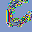

In [ ]:
T.ToPILImage()(train_dataset.__getitem__(1)[0][1])

In [ ]:
T.ToPILImage()(train_dataset.__getitem__(1)[0][0])

In [ ]:
T.ToPILImage()(trainset[700][0]).resize((28,28))

In [ ]:
T.ToPILImage()(trainset[11990][0]).resize((28,28))

In [ ]:
trainset.labels[11990]

1

In [ ]:
trainset.group_partition[(1,0)]

[5591,
 7053,
 7692,
 9781,
 11990,
 12316,
 12942,
 13635,
 15162,
 16778,
 17699,
 18683,
 20997,
 22499,
 24143,
 24251,
 28402,
 39663,
 41096]